In [28]:
# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from feature_extraction import texture_statistics_gabor, texture_statistics_pyramid, bdcn_features, sketch_token_features
from utils import nsd_utils, roi_utils

bdcn_path = '/user_data/mmhender/toolboxes/BDCN/'

from model_fitting import initialize_fitting, merge_features, fwrf_fit, fwrf_predict

fpX = np.float32
device = 'cpu:0'
# device = initialize_fitting.init_cuda()

In [29]:
fitting_type='pyramid_texture'
do_avg_pool=True
subject=1
volume_space = True
up_to_sess = 1
n_ori = 4
n_sf = 4
nonlin_fn = False
padding_mode = 'circular';
group_all_hl_feats = True; \
sample_batch_size = 50; voxel_batch_size = 100; \
zscore_features = True; ridge = True; \
shuffle_images = False; random_images = False; random_voxel_data = False; \
do_fitting = True; do_val = True; do_varpart = True; date_str = None;
shuff_rnd_seed = 0; debug = True; \
do_pca = False; min_pct_var = 99; max_pc_to_retain = 400; map_ind = -1; \
n_prf_sd_out = 2; mult_patch_by_prf = True; \
downsample_factor = 1.0; do_nms = False

In [30]:
if 'pyramid' in fitting_type:
    model_name = initialize_fitting.get_pyramid_model_name(ridge, n_ori, n_sf)
    feature_types_exclude = []        
    name1 = 'pyramid_texture'

elif 'gabor_texture' in fitting_type:        
    model_name = initialize_fitting.get_gabor_texture_model_name(ridge, n_ori, n_sf)
    feature_types_exclude = []
    name1 = 'gabor_texture'

elif 'gabor_solo' in fitting_type:        
    model_name = initialize_fitting.get_gabor_solo_model_name(ridge, n_ori, n_sf)
    feature_types_exclude = ['pixel', 'simple_feature_means', 'autocorrs', 'crosscorrs']
    name1 = 'gabor_solo'

elif 'bdcn' in fitting_type:
    model_name = initialize_fitting.get_bdcn_model_name(do_pca, map_ind)   
    name1 = 'bdcn'

elif 'sketch_tokens' in fitting_type:
    model_name = initialize_fitting.get_sketch_tokens_model_name(do_pca)   
    name1 = 'sketch_tokens'

else:
    raise ValueError('your string for fitting_type was not recognized')

if 'plus_sketch_tokens' in fitting_type:
    model_name2 = initialize_fitting.get_sketch_tokens_model_name(do_pca)
    model_name = model_name + '_plus_' + model_name2
elif 'plus_bdcn' in fitting_type:
    model_name2 = initialize_fitting.get_bdcn_model_name(do_pca, map_ind)
    model_name = model_name + '_plus_' + model_name2


output_dir, fn2save = initialize_fitting.get_save_path(subject, volume_space, model_name, shuffle_images, random_images, random_voxel_data, debug, date_str)

# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, volume_space)

sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, sessions=sessions, \
                                                                     voxel_mask=voxel_mask, volume_space=volume_space, \
                                                                      zscore_betas_within_sess=zscore_betas_within_sess, \
                                                                      shuffle_images=shuffle_images, random_images=random_images, \
                                                                                         random_voxel_data=random_voxel_data)


if 'gabor' in fitting_type or 'sketch_tokens' in fitting_type or 'pyramid' in fitting_type:
    # For this model, the features are pre-computed, so we will just load them rather than passing in images.
    # Going to pass the image indices (into 10,000 dim array) instead of images to fitting and val functions, 
    # which will tell which features to load.
    trn_stim_data = image_order_trn
    val_stim_data = image_order_val


Time Stamp: Sep-21-2021_2248_15

Will save final output file to /user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf/Sep-21-2021_2248_15_DEBUG/


Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
0 voxels of overlap between face and place definitions, using place defs
unique values in categ labels:
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]
1535 voxels are defined (differently) in both retinotopic areas and category areas

14913 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all ROIs:
[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2

In [31]:
     
# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    
    


Possible lambda values are:
[1.0000000e+00 4.2169652e+00 1.7782795e+01 7.4989418e+01 3.1622775e+02
 1.3335215e+03 5.6234131e+03 2.3713736e+04 1.0000000e+05]
most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [7]:
 
do_pca_pyr_hl = True
do_pca_st = True

group_all_hl_feats = True
feature_types_exclude =[]
# Set up the pyramid
compute_features = False
_fmaps_fn = steerable_pyramid_extractor(pyr_height = n_sf, n_ori = n_ori)
# Initialize the "texture" model which builds on first level feature maps
_feature_extractor1 = texture_feature_extractor(_fmaps_fn,sample_batch_size=sample_batch_size, \
                  subject=subject, feature_types_exclude=feature_types_exclude, n_prf_sd_out=n_prf_sd_out, \
                                               aperture=aperture, do_varpart = do_varpart, \
                              group_all_hl_feats = group_all_hl_feats, compute_features = compute_features, \
                               do_pca_hl=do_pca_pyr_hl, min_pct_var = min_pct_var, max_pc_to_retain = max_pc_to_retain, \
                               device=device)
# feature_info = [_feature_extractor.feature_column_labels, _feature_extractor.feature_types_include]
        

Feature types to exclude from the model:
[]


In [72]:
do_pca_pyr_hl = True
do_pca_st = True

map_resolution = 227
_feature_extractor = sketch_token_feature_extractor(subject, device, map_resolution=map_resolution, \
                                                                           aperture = aperture, \
                                                     n_prf_sd_out = n_prf_sd_out, \
                               batch_size=sample_batch_size, mult_patch_by_prf=mult_patch_by_prf, do_avg_pool = do_avg_pool,\
                                           do_pca = do_pca_st, min_pct_var = min_pct_var, max_pc_to_retain = max_pc_to_retain)
# _feature_extractor = merge_features.combined_feature_extractor([_feature_extractor1, _feature_extractor2], \
#                                                                    [name1,'sketch_tokens'], do_varpart = do_varpart)


In [82]:
mm=2
_feature_extractor.init_for_fitting((240,240), models, dtype=np.float32)
feats, defined = _feature_extractor(val_stim_data, models[mm], mm, fitting_mode=True)

Initializing for fitting
Initializing arrays for PCA params
Clearing features from memory
Loading pre-computed features from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf.h5py


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Took 16.80951 seconds to load file
Size of features array for this image set is:
(62, 151, 875)
Preparing for PCA: original dims of features:
(62, 151)
Running PCA...
Retaining 22 components to expl 99 pct var
Final size of feature matrix is:
(62, 22)


In [83]:
feats, defined = _feature_extractor(val_stim_data, models[mm], mm, fitting_mode=False)

Preparing for PCA: original dims of features:
(62, 151)
Applying pre-computed PCA matrix...
Final size of feature matrix is:
(62, 22)


In [84]:
feats.shape

torch.Size([62, 22])

In [71]:
import numpy as np
import sys, os
import torch
import time
import h5py
import torch.nn as nn
from sklearn import decomposition

from utils import prf_utils, torch_utils, texture_utils, default_paths
sketch_token_feat_path = default_paths.sketch_token_feat_path

class sketch_token_feature_extractor(nn.Module):
    
    def __init__(self, subject, device, map_resolution=227, aperture = 1.0, n_prf_sd_out = 2, \
                 batch_size=100, mult_patch_by_prf=True, do_avg_pool = True, \
                 do_pca = True, min_pct_var = 99, max_pc_to_retain = 100):
        
        super(sketch_token_feature_extractor, self).__init__()
        
        self.subject = subject
        
        self.features_file = os.path.join(sketch_token_feat_path, 'S%d_features_each_prf.h5py'%(subject))
        if not os.path.exists(self.features_file):
            raise RuntimeError('Looking at %s for precomputed features, not found.'%self.features_file)
        with h5py.File(self.features_file, 'r') as data_set:
            ds_size = np.shape(data_set['/features'])
        self.n_features = ds_size[1]
        self.device = device
          
        self.map_resolution = map_resolution
        self.aperture = aperture
        self.n_prf_sd_out = n_prf_sd_out
        self.batch_size = batch_size
        self.mult_patch_by_prf = mult_patch_by_prf
        self.do_avg_pool = do_avg_pool # else max pool
        
        self.do_pca = do_pca
        if self.do_pca:
            self.min_pct_var = min_pct_var
            self.max_pc_to_retain = np.min([self.n_features, max_pc_to_retain])
        else:
            self.min_pct_var = None
            self.max_pc_to_retain = None  
            
        self.do_varpart=False # only one set of features in this model for now, not doing variance partition
        self.features_each_prf = None
        
    def init_for_fitting(self, image_size, models, dtype):

        """
        Additional initialization operations which can only be done once we know image size and
        desired set of candidate prfs.
        """
        
        print('Initializing for fitting')
        n_prfs = len(models)
        n_feat_each_prf = self.n_features * np.ones(shape=(n_prfs,),dtype=int)      
        self.n_feat_each_prf = n_feat_each_prf
        
        if self.do_pca:
            
            print('Initializing arrays for PCA params')
            # will need to save pca parameters to reproduce it during validation stage
            # max pc to retain is just to save space, otherwise the "pca_wts" variable becomes huge  
            self.max_features = self.max_pc_to_retain
            self.pca_wts = [np.zeros(shape=(self.max_pc_to_retain, n_feat_each_prf[mm]), dtype=dtype) for mm in range(n_prfs)] 
            self.pca_pre_z_mean = [np.zeros(shape=(n_feat_each_prf[mm],), dtype=dtype) for mm in range(n_prfs)]
            self.pca_pre_z_std = [np.zeros(shape=(n_feat_each_prf[mm],), dtype=dtype) for mm in range(n_prfs)]
            self.pca_pre_mean = [np.zeros(shape=(n_feat_each_prf[mm],), dtype=dtype) for mm in range(n_prfs)]
            self.pct_var_expl = np.zeros(shape=(self.max_pc_to_retain, n_prfs), dtype=dtype)
            self.n_comp_needed = np.full(shape=(n_prfs), fill_value=-1, dtype=int)

        else:
            self.max_features = np.max(n_feat_each_prf)
       
        self.clear_big_features()
        
    def get_partial_versions(self):

        if not hasattr(self, 'max_features'):
            raise RuntimeError('need to run init_for_fitting first')
           
        partial_version_names = ['full_model']
        masks = np.ones([1,self.max_features])

        return masks, partial_version_names

    def load_precomputed_features(self, image_inds):
        
        print('Loading pre-computed features from %s'%self.features_file)
        t = time.time()
        with h5py.File(self.features_file, 'r') as data_set:
            values = np.copy(data_set['/features'])
            data_set.close() 
        elapsed = time.time() - t
        print('Took %.5f seconds to load file'%elapsed)
        
        self.features_each_prf = values[image_inds,:,:]
        
        print('Size of features array for this image set is:')
        print(self.features_each_prf.shape)
        
    def clear_big_features(self):
        
        print('Clearing features from memory')
        self.features_each_prf = None 
    
    def forward(self, image_inds, prf_params, prf_model_index, fitting_mode = True):
        
        if self.features_each_prf is None:
            self.load_precomputed_features(image_inds)
        else:
            assert(self.features_each_prf.shape[0]==len(image_inds))
            
        # Taking the features for the desired prf model
        features = self.features_each_prf[:,:,prf_model_index]
        
        if self.do_pca:    
            features = self.reduce_pca(features, prf_model_index, fitting_mode)

        print('Final size of feature matrix is:')
        print(features.shape)
        
        features = torch_utils._to_torch(features, self.device)
        
        feature_inds_defined = np.zeros((self.max_features,), dtype=bool)
        feature_inds_defined[0:features.shape[1]] = 1
            
        return features, feature_inds_defined
     
        
    def reduce_pca(self, features, prf_model_index, fitting_mode=True):
        
        if torch.is_tensor(features):
            features = features.detach().cpu().numpy()
            was_tensor=True
        else:
            was_tensor=False
            
        n_trials = features.shape[0]
        n_features_actual = features.shape[1]
        assert(n_features_actual == self.n_feat_each_prf[prf_model_index])
        print('Preparing for PCA: original dims of features:')
        print(features.shape)
        
        if fitting_mode:
            
            # Going to perform pca on the raw features
            # First make sure it hasn't been done yet!
            assert(self.n_comp_needed[prf_model_index]==-1) 
            print('Running PCA...')
            pca = decomposition.PCA(n_components = np.min([np.min([self.max_pc_to_retain, n_features_actual]), n_trials]), copy=False)
            # for this model, need to normalize the columns otherwise the last one dominates...
            features_m = np.mean(features, axis=0, keepdims=True) #[:trn_size]
            features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
            features -= features_m
            features /= features_s 
            self.pca_pre_z_mean[prf_model_index][0:n_features_actual] = features_m
            self.pca_pre_z_std[prf_model_index][0:n_features_actual] = features_s
            
            # Perform PCA to decorrelate feats and reduce dimensionality
            scores = pca.fit_transform(features)           
            features = None            
            wts = pca.components_
            ev = pca.explained_variance_
            ev = ev/np.sum(ev)*100
            # wts/components goes [ncomponents x nfeatures]. 
            # nfeatures is always actual number of raw features
            # ncomponents is min(ntrials, nfeatures)
            # to save space, only going to save up to some max number of components.
            n_components_actual = np.min([wts.shape[0], self.max_pc_to_retain])
            # save a record of the transformation to be used for validating model
            self.pca_wts[prf_model_index][0:n_components_actual,0:n_features_actual] = wts[0:n_components_actual,:] 
            # mean of each feature, nfeatures long - needed to reproduce transformation
            self.pca_pre_mean[prf_model_index][0:n_features_actual] = pca.mean_ 
            # max len of ev is the number of components
            self.pct_var_expl[0:n_components_actual,prf_model_index] = ev[0:n_components_actual]  
            n_components_reduced = int(np.where(np.cumsum(ev)>self.min_pct_var)[0][0] if np.any(np.cumsum(ev)>self.min_pct_var) else len(ev))
            n_components_reduced = np.max([n_components_reduced, 1])
            self.n_comp_needed[prf_model_index] = n_components_reduced
            print('Retaining %d components to expl %d pct var'%(n_components_reduced, self.min_pct_var))
            assert(n_components_reduced<=self.max_pc_to_retain)            
            features_reduced = scores[:,0:n_components_reduced]
           
        else:
            
            # This is a validation pass, going to use the pca pars that were computed on training set
            # Make sure it has been done already!
            assert(self.n_comp_needed[prf_model_index]!=-1)
            print('Applying pre-computed PCA matrix...')
            # Apply the PCA transformation, just as it was done during training
            features -= np.tile(np.expand_dims(self.pca_pre_z_mean[prf_model_index], axis=0), [n_trials, 1])
            features /= np.tile(np.expand_dims(self.pca_pre_z_std[prf_model_index], axis=0), [n_trials, 1])
            
            features_submean = features - np.tile(np.expand_dims(self.pca_pre_mean[prf_model_index][0:n_features_actual], axis=0), [n_trials, 1])
            features_reduced = features_submean @ np.transpose(self.pca_wts[prf_model_index][0:self.n_comp_needed[prf_model_index],0:n_features_actual])               
                       
        features = None
        
        if was_tensor:
            features_reduced = torch.tensor(features_reduced).to(self.device)
        
        return features_reduced
    

def get_features_each_prf(features_file, models, mult_patch_by_prf=True, do_avg_pool=True, \
                          batch_size=100, aperture=1.0, debug=False, device=None):
    """
    Extract the portion of the feature maps corresponding to each prf in 'models'
    Start with loading the feature maps h5py file (generated by get_st_features.m)
    Save smaller features as an h5py file [n_images x n_features x n_prfs]
    """
    if device is None:
        device = 'cpu:0'
        
    with h5py.File(features_file, 'r') as data_set:
        ds_size = data_set['/features'].shape
    n_images = ds_size[3]
    n_features = ds_size[0]
    map_resolution = ds_size[1]
    n_prfs = models.shape[0]
    features_each_prf = np.zeros((n_images, n_features, n_prfs))
    n_batches = int(np.ceil(n_images/batch_size))

    for bb in range(n_batches):

        if debug and bb>1:
            continue

        batch_inds = np.arange(batch_size * bb, np.min([batch_size * (bb+1), n_images]))

        print('Loading features for images [%d - %d]'%(batch_inds[0], batch_inds[-1]))
        st = time.time()
        with h5py.File(features_file, 'r') as data_set:
            # Note this order is reversed from how it was saved in matlab originally.
            # The dimensions go [features x h x w x images]
            # Luckily h and w are swapped matlab to python anyway, so can just switch the first and last.
            values = np.copy(data_set['/features'][:,:,:,batch_inds])
            data_set.close()  
        fmaps_batch = np.moveaxis(values, [0,1,2,3],[3,1,2,0])

        elapsed = time.time() - st
        print('Took %.5f sec to load feature maps'%elapsed)

        maps_full_field = torch_utils._to_torch(fmaps_batch, device=device)

        for mm in range(n_prfs):

            if debug and mm>1:
                continue

            prf_params = models[mm,:]
            x,y,sigma = prf_params
            print('Getting features for pRF [x,y,sigma]:')
            print([x,y,sigma])
            n_pix = map_resolution

             # Define the RF for this "model" version
            prf = torch_utils._to_torch(prf_utils.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, \
                                      dtype=np.float32)[2], device=device)
            minval = torch.min(prf)
            maxval = torch.max(prf-minval)
            prf_scaled = (prf - minval)/maxval

            if mult_patch_by_prf:         
                # This effectively restricts the spatial location, so no need to crop
                maps = maps_full_field * prf_scaled.view([1,map_resolution,map_resolution,1])
            else:
                # This is a coarser way of choosing which spatial region to look at
                # Crop the patch +/- n SD away from center
                n_pf_sd_out = 2
                bbox = texture_utils.get_bbox_from_prf(prf_params, prf.shape, n_prf_sd_out, min_pix=None, verbose=False, force_square=False)
                print('bbox to crop is:')
                print(bbox)
                maps = maps_full_field[:,bbox[0]:bbox[1], bbox[2]:bbox[3],:]

            if do_avg_pool:
                features_batch = torch.mean(maps, dim=(1,2))
            else:
                features_batch = torch.max(maps, dim=(1,2))
                
            print('model %d, min/max of features in batch: [%s, %s]'%(mm, torch.min(features_batch), torch.max(features_batch))) 

            features_each_prf[batch_inds,:,mm] = torch_utils.get_value(features_batch)
                      
    return features_each_prf

In [65]:
features = feats
prf_model_index = mm
fitting_mode = True
if torch.is_tensor(features):
    features = features.detach().cpu().numpy()
    was_tensor=True
else:
    was_tensor=False

n_trials = features.shape[0]
n_features_actual = features.shape[1]
assert(n_features_actual == _feature_extractor.n_feat_each_prf[prf_model_index])
print('Preparing for PCA: original dims of features:')
print(features.shape)

Preparing for PCA: original dims of features:
(62, 151)


In [54]:
_feature_extractor.max_pc_to_retain = 400
_feature_extractor.min_pct_var = 99

In [62]:
# Going to perform pca on the raw features
# First make sure it hasn't been done yet!
# assert(_feature_extractor.n_comp_needed[prf_model_index]==-1) 
print('Running PCA...')
pca = decomposition.PCA(n_components = np.min([np.min([_feature_extractor.max_pc_to_retain, n_features_actual]), n_trials]), copy=False)
# Perform PCA to decorrelate feats and reduce dimensionality
scores = pca.fit_transform(features)           
features = None            
wts = pca.components_
ev = pca.explained_variance_
ev = ev/np.sum(ev)*100
# wts/components goes [ncomponents x nfeatures]. 
# nfeatures is always actual number of raw features
# ncomponents is min(ntrials, nfeatures)
# to save space, only going to save up to some max number of components.
n_components_actual = np.min([wts.shape[0], _feature_extractor.max_pc_to_retain])
# save a record of the transformation to be used for validating model
# _feature_extractor.pca_wts[prf_model_index][0:n_components_actual,0:n_features_actual] = wts[0:n_components_actual,:] 
# mean of each feature, nfeatures long - needed to reproduce transformation
# _feature_extractor.pca_pre_mean[prf_model_index][0:n_features_actual] = pca.mean_ 
# max len of ev is the number of components
# _feature_extractor.pct_var_expl[0:n_components_actual,prf_model_index] = ev[0:n_components_actual]  
n_components_reduced = int(np.where(np.cumsum(ev)>_feature_extractor.min_pct_var)[0][0] if np.any(np.cumsum(ev)>_feature_extractor.min_pct_var) else len(ev))
n_components_reduced = np.max([n_components_reduced, 1])
# _feature_extractor.n_comp_needed[prf_model_index] = n_components_reduced
print('Retaining %d components to expl %d pct var'%(n_components_reduced, _feature_extractor.min_pct_var))
assert(n_components_reduced<=_feature_extractor.max_pc_to_retain)            
features_reduced = scores[:,0:n_components_reduced]

Running PCA...
Retaining 1 components to expl 99 pct var


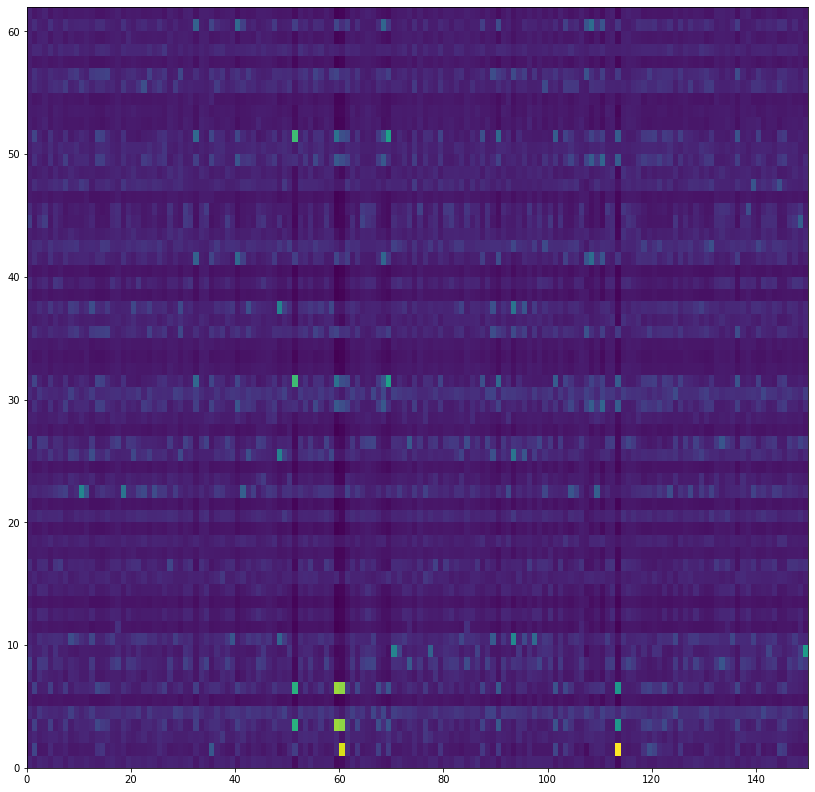

In [70]:
plt.figure(figsize=(14,14));
plt.pcolormesh(features[:,0:150])

In [68]:
np.mean(features, axis=0)

array([-1.5815306e-14, -3.3005855e-14, -2.0170245e-14, -2.2462319e-14,
       -4.4007807e-14,  9.1682931e-15, -1.1001952e-14, -4.0340490e-14,
        0.0000000e+00, -1.8336586e-14,  3.6673172e-15, -2.7504879e-14,
       -1.1001952e-14,  3.6673172e-14,  0.0000000e+00, -3.6673172e-14,
        3.6673172e-15, -6.4178052e-15, -1.4669269e-14, -1.8336586e-14,
        3.6673172e-14, -3.6673172e-15, -2.2003903e-14, -5.8677076e-14,
       -3.6673172e-15,  2.2003903e-14,  2.2003903e-14,  1.9253416e-14,
        2.9338538e-14,  0.0000000e+00, -3.6673172e-15,  2.7504879e-14,
        2.2003903e-14,  2.7504879e-15,  1.1918781e-14,  1.1918781e-13,
       -2.5671221e-14,  3.3005855e-14, -3.3005855e-14,  3.1172198e-14,
        8.0680979e-14,  1.4669269e-14,  7.3346345e-15, -3.6673172e-15,
        5.3176102e-14,  5.1342441e-14,  3.6673172e-15, -4.7675124e-14,
       -2.9338538e-14,  2.5671221e-14, -4.0340490e-14,  8.0680979e-14,
        2.9338538e-14,  3.6673172e-14, -4.4007807e-14,  4.4007807e-14,
      

In [41]:
_feature_extractor.pca_wts[2]

array([[ 0.00245485,  0.00672593,  0.00492353, ...,  0.00344858,
         0.00668965, -0.99591285],
       [-0.04739868,  0.08239121, -0.04661044, ..., -0.05576875,
        -0.06590424,  0.03195803],
       [ 0.06343289, -0.01247802,  0.03169131, ...,  0.10604736,
         0.04479181, -0.00742254],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

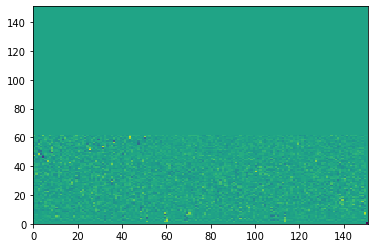

In [42]:
import matplotlib.pyplot as plt
plt.pcolormesh(_feature_extractor.pca_wts[2])

In [38]:
# np.cumsum(_feature_extractor.pct_var_expl[:,mm])

array([98.770065, 99.39865 , 99.55419 , 99.66115 , 99.74617 , 99.806885,
       99.84795 , 99.88618 , 99.90486 , 99.91882 , 99.930244, 99.94002 ,
       99.94772 , 99.9545  , 99.96038 , 99.96571 , 99.97029 , 99.9743  ,
       99.97815 , 99.98136 , 99.98441 , 99.986946, 99.98938 , 99.9914  ,
       99.99295 , 99.994316, 99.99519 , 99.99603 , 99.99686 , 99.99754 ,
       99.99811 , 99.998505, 99.998856, 99.999176, 99.99936 , 99.99951 ,
       99.99963 , 99.99974 , 99.99982 , 99.999886, 99.99994 , 99.99997 ,
       99.999985, 99.99999 , 99.99999 , 99.99999 , 99.99999 , 99.99999 ,
       99.99999 , 99.99999 , 99.99999 , 99.99999 , 99.99999 , 99.99999 ,
       99.99999 , 99.99999 , 99.99999 , 99.99999 , 99.99999 , 99.99999 ,
       99.99999 , 99.99999 , 99.99999 , 99.99999 , 99.99999 , 99.99999 ,
       99.99999 , 99.99999 , 99.99999 , 99.99999 , 99.99999 , 99.99999 ,
       99.99999 , 99.99999 , 99.99999 , 99.99999 , 99.99999 , 99.99999 ,
       99.99999 , 99.99999 , 99.99999 , 99.99999 , 

In [15]:
feats, defined = _feature_extractor(val_stim_data, models[mm], mm, fitting_mode=False)

Index into batch for prf 2: 2
Size of features array for this image set and prf is:
(62, 641)
Final size of features concatenated is [62 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [62 x 641]
Running PCA on higher-level features...
Preparing for PCA: original dims of features:
(62, 592)
Applying pre-computed PCA matrix...
Final size of features concatenated is [62 x 51]
Preparing for PCA: original dims of features:
(62, 151)
Applying pre-computed PCA matrix...
Final size of feature matrix is:
(62, 1)


In [16]:
defined.shape

(600,)

In [28]:
_feature_extractor.modules[0].max_features

449

In [29]:
_feature_extractor.modules[1].max_features

151

In [17]:
pc = []
for m in _feature_extractor.modules:           
    if hasattr(m, 'pct_var_expl'):
        pcm = [m.pct_var_expl, m.min_pct_var,  m.n_comp_needed]                  
    else:
        pcm = None
    pc.append(pcm)

In [23]:
pc[0][0]

array([[ 0.        ,  0.        , 98.06194   , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.7108457 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.49869698, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [17]:
torch.cat((feats, feats2), axis=1)

tensor([[ 4.1239e-01,  4.9881e-03,  3.6118e-02,  ..., -1.7653e+02,
         -1.7898e+01, -7.5757e-05],
        [ 3.7503e-02,  6.5405e-03,  2.0029e+00,  ..., -1.8690e+02,
         -1.1006e+01,  1.4115e-04],
        [ 2.0118e-01,  4.4240e-03,  1.1431e+00,  ..., -1.7151e+02,
         -1.0463e+01,  2.8603e-05],
        ...,
        [ 1.5854e-02,  5.0241e-05,  1.2342e+00,  ...,  1.2241e+03,
          6.5767e+00, -3.6620e-04],
        [ 2.7447e-01,  1.8736e-02,  1.6470e+00,  ..., -2.3180e+01,
         -1.4085e+01,  3.3083e-04],
        [ 5.7150e-02,  1.9648e-05,  2.8961e+00,  ..., -1.9614e+02,
         -1.2480e+01, -4.2701e-04]])

In [38]:
feats, defined = _feature_extractor(val_stim_data, models[mm], mm, fitting_mode=False)

Index into batch for prf 2: 2
Size of features array for this image set and prf is:
(62, 641)
Final size of features concatenated is [62 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [62 x 641]
Running PCA on higher-level features...
Preparing for PCA: original dims of features:
(62, 592)
Applying pre-computed PCA matrix...
Final size of features concatenated is [62 x 51]


In [27]:
_feature_extractor.modules[0].get_partial_versions()[0].shape

(3, 641)

In [36]:
np.where(defined==False)[0][0]

51

In [64]:
# _feature_extractor.n_comp_needed

In [66]:
hasattr(_feature_extractor, 'pct_kdfvar_expl')

False